In [11]:
!nrnivmodl /home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
import numpy as np
from scipy.optimize import minimize
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
# 自定义刻度标签显示格式

from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位

def plot_curve(ax2,x,y,color='black',title='', linestyle='-',xlim=[0,100],dx=20,
               ylim=[0,10],dy=5.0, fontsize=10, alpha = 1.0, xlabel='Time/ms', 
               ylabel = 'Frequency/Hz', label='',ynum_decimals =1, 
               nonscatter=True, s0=10):
    if nonscatter:
        if color:
            ax2.plot(x,y,color=color,linewidth=2,linestyle=linestyle,alpha=alpha, label=label)
        else:
            ax2.plot(x,y,linewidth=2,alpha=alpha, linestyle=linestyle,label=label)
    else:
        if color:
            ax2.scatter(x,y,color=color,linewidth=2,linestyle=linestyle,alpha=alpha, 
                        label=label, s=s0)
        else:
            ax2.scatter(x,y,linewidth=2,alpha=alpha, linestyle=linestyle,label=label,
                        s=s0)
        
    ax2.set_xlabel(xlabel,font2)
    ax2.set_ylabel(ylabel,font2)
    
    # def format_funcx(value, tick_number, num_decimals=xnum_decimals):
    #     if num_decimals==0:
    #         return f'{value:.0f}'
    #     return f'{value:.{num_decimals}f}'

    def format_funcy(value, tick_number, num_decimals=ynum_decimals):
        if num_decimals==0:
          return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    # if dx:
    #     ax2.set_xticks(np.arange(xlim[0], xlim[1] + dx, dx))
    #     ax2.set_xticklabels(ax2.get_xticks(), fontsize=fontsize, weight='bold')
    #     ax2.set_xlim([xlim[0], xlim[1]])
    #     ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))

    if dy:
        ax2.set_yticks(np.arange(ylim[0], ylim[1] + dy, dy))
        ax2.set_yticklabels(ax2.get_yticks(), fontsize=fontsize, weight='bold')
        ax2.set_ylim([ylim[0], ylim[1]])
        ax2.yaxis.set_major_formatter(FuncFormatter(format_funcy))
        
  
    if xlim:
       ax2.set_xticks(np.arange(xlim[0],xlim[1]+dx,dx))
       ax2.set_xticklabels(np.arange(xlim[0],xlim[1]+dx,dx),fontsize= fontsize,weight='bold')
       ax2.set_xlim(xlim)
    # if ylim:
    #    ax2.set_yticks(np.arange(ylim[0],ylim[1]+dy,dy))
    #    ax2.set_yticklabels(np.arange(ylim[0],ylim[1]+dy,dy),fontsize=10,weight='bold')
    #    ax2.set_ylim(ylim)
    if title:
       ax2.set_title('{0}'.format(title),fontsize=fontsize,weight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    if label:
       ax2.legend(loc='best',prop=font2,edgecolor='white')

h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/morphologies/cell1.asc"
biophysicalModelFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
def exp_fitting(x,y, num=2):
    
    if num==2:
        # Calculate integrals
        iy1 = cumtrapz(y, x, initial=0)
        iy2 = cumtrapz(iy1, x, initial=0)


        # Get exponentials lambdas
        Y = np.column_stack((iy1, iy2,  x**2, x, np.ones_like(x)))
        A = pinv(Y) @ y
        
        if A[0]**2 + 4*A[1]<0:
            # 定义目标函数
            def objective(t):
                return np.linalg.norm(Y @ t - y)

            # 定义约束函数
            def constraint(t):
                return t[0]**2 + 4*t[1]

            # 初始猜测
            x0 = np.array([0, 0, 0, 0, 0])

            # 定义约束
            cons = {'type': 'ineq', 'fun': constraint}

            # 设置迭代次数
            options = {'maxiter': 10000}  # 将最大迭代次数设置为1000

            # 使用scipy.optimize.minimize求解问题
            solution = minimize(objective, x0, constraints=cons, options=options)
            A = solution.x


        lambdas = eig(np.array([[A[0], A[1]], [1, 0]]))[0]
        # print("Lambdas:", lambdas)

        # Get exponentials multipliers
        X = np.column_stack((np.ones_like(x), np.exp(lambdas[0] * x), np.exp(lambdas[1] * x)))
        P = pinv(X) @ y
        # print("Multipliers:", P)
    
    # if num==1:
    #     iy1 = cumtrapz(y, x, initial=0)

    #     # Get exponentials lambdas
    #     Y = np.column_stack((iy1, x, np.ones_like(x)))
    #     A = pinv(Y) @ y

    #     lambdas = A[0]
    #     # print("Lambdas:", lambdas)


    #     # Get exponentials multipliers
    #     X = np.column_stack((np.ones_like(x), np.exp(lambdas * x)))
    #     P = pinv(X) @ y
    #     # print("Multipliers:", P)
    
    return lambdas, P

def time_constant_fitting(run_dt, dtime, fE, passive=False, E = True, loc=58,
                          block='',name= '', location ='dend', plot = False,
                          setIh = False, gIhbar_Ih = 0.):
    
    L5PC = h.L5PCtemplate(morphologyFilename)

    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    if setIh:
        for sec in h.allsec():
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = gIhbar_Ih
             
    # Set simulation parameters
    h.dt = run_dt
    h.tstop = 200.
    h.v_init = -77.
    v_clamp = -77.


    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()

    # attach it to a synapse
    if location == 'dend':
        syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
    if location == 'apic':
        syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        if passive:
            syn.e = 0.  # mV for E input and -100 for I input
        else: 
            syn.e = 13.6
    else:
        if passive: 
            syn.e = -100.
        else:
            syn.e = -86.4
    # print(syn.e)
        
    stim.number = 1
    stim.start = 100.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = 0e-2  # uS


    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = v_clamp
    vclamp.dur2 = h.tstop
    vclamp.amp2 = v_clamp - 20.

    irec = h.Vector()
    irec.record(vclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        # vol = h.Vector()
    
        # savdata = open("neuron_voltage.dat", "w")
        T = 200./run_dt+1
        N = int(10./dtime)
        data = np.zeros((2*N, int(T)))


        for i in range(1, N+1):
            vclamp.dur1 = 100. + i * dtime

            ncstim.weight[0] = 0e-2
            go()
            # data[4*(i-1),:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1),:] = irec.to_python()  # Assuming irec is a NEURON Vector

            
            ncstim.weight[0] = fE
            go()
            # data[4*(i-1)+2,:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1)+1,:] = irec.to_python()  # Assuming irec is a NEURON Vector

        # np.savetxt("neuron_voltage.txt", data)
        # print("Done data!")
        I_w_ng = data[::2, :]
        I_w_g = data[1::2, :]
        diff_I = I_w_ng - I_w_g
        x = np.arange(0.1, 10.1, dtime) # ms
        y = -np.sum(diff_I, axis=1)  # size of 100

        result_lambdas, result_multipliers = exp_fitting(x, y, num=2)
        if plot:
            plt.plot(x, y, 'b', label='data')
            plt.plot(x, result_multipliers[0]+result_multipliers[1]*np.exp(result_lambdas[0]*x) + result_multipliers[2]*np.exp(result_lambdas[1]*x), 'r', label='fit')
            plt.legend()
        
        return result_lambdas, y
    
    
    result_lambdas, y = main()
    return result_lambdas, y
    

/home/wzl/anaconda/envs/neuron9/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO : Using neuron-nightly Package (Developer Version)
/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron
cfiles =
Mod files: "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/CaDynamics_E2.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_HVA.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_LVAst.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/epsp.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ih.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Im.mod" "/home/wzl/LFPy/project/conductance_measurement/real

# parallel location

In [9]:
result_lambdas, y = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = False, E = True, block='', name='', 
        loc = 34, location = 'apic', setIh = False, gIhbar_Ih = 0.0002/20.)

/tmp/ipykernel_2922623/1375962700.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)


In [10]:
-1./result_lambdas

array([5.3200648, 6.6010954])

In [3]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    result_lambdas, y = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = False, E = True, block='', name='', 
        loc = loc0[1], location = loc0[0], setIh = True, gIhbar_Ih = 0.0002/20.)
     
    return result_lambdas

 
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((Num, 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
np.savetxt("estimated_lambdas_active_alldend_fE5e4_twice_clamp_gIhbar_Ih0_05_relative_reversal_potential.txt", estimated_lambdas)

/tmp/ipykernel_2922623/1375962700.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecate

In [14]:
estimated_lambdas[34,:]

array([-0.95830589, -0.20258714])

In [5]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    result_lambdas, y = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = False, E = True, block='', name='', 
        loc = loc0[1], location = loc0[0], setIh = True, gIhbar_Ih = 0.0)
     
    return result_lambdas

 
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((Num, 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
np.savetxt("estimated_lambdas_active_alldend_fE5e4_twice_clamp_blockIh_relative_reversal_potential.txt", estimated_lambdas)

/tmp/ipykernel_2922623/1375962700.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)
/tmp/ipykernel_2922623/1375962700.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecate

# PSP

In [ ]:
def caculatePSP(fE, passive=False, E = True, loc=58, block='',name= ''):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    recv = h.Vector()
    recv.record(L5PC.soma[0](0.5)._ref_v)
    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.

    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0)
    
    
    # Set simulation parameters
    h.dt = 0.1
    h.tstop = 500
    if passive:
       h.v_init = -90.
    else:
       h.v_init = -77.


    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()

    # attach it to a synapse
    syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        syn.e = 0.  # mV for E input and -100 for I input
    else: 
        syn.e = -100.
    # print(syn.e)
        
    stim.number = 1
    stim.start = 400.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = fE  # uS

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        
        go()
        
        v_array = recv.to_python()
        V_cut = v_array[3500:]
        PSP = np.max(V_cut) - np.min(V_cut)

        return PSP
    
    PSP = main()
    return PSP        

In [78]:
# Your existing functions and code
# "na3", gbar_na3 = 0.*
# "h", ghdbar_h = 0.*
# "kadist", gkabar_kadist = 0.*
# "kaprox", gkabar_kaprox = 0.*
# "kdrca1", gkdrbar_kdrca1 = 0.*
# "nax", gbar_nax = 0. *
# "Ca_HVA", gCa_HVAbar_Ca_HVA = 0. * (**)
# "Ca_LVAst", gCa_LVAstbar_Ca_LVAst = 0. *(**)
# "Ih", gIhbar_Ih = 0. *(***)
# "Im", gImbar_Im = 0. *(**)
# "K_Pst", gK_Pstbar_K_Pst = 0.* (**)
# "K_Tst", gK_Tstbar_K_Tst = 0. *(**)
# "Nap_Et2", gNap_Et2bar_Nap_Et2 = 0. *(**)
# "NaTa_t", gNaTa_tbar_NaTa_t = 0. *(**)
# "NaTs2_t", gNaTs2_tbar_NaTs2_t = 0. *
# "SK_E2", gSK_E2bar_SK_E2 = 0. *(***)
# "SKv3_1",gSKv3_1bar_SKv3_1 = 0. *(***)
def caculatePSP_parallel(args):
    fE0, = args
    PSP = caculatePSP(fE0, passive=False, E = True, loc=58, block='SKv3_1', name='gSKv3_1bar_SKv3_1')
    return PSP

fE = np.linspace(1e-4, 1e-3, 100)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(fE0,) for fE0 in fE]

    # Apply the function in parallel
    results = pool.map(caculatePSP_parallel, args_list)

# Process the results
PSP = np.zeros(len(fE))
for i, result in enumerate(results):
    PSP[i] = result
    
# np.savetxt("EPSP_active_fE.txt",PSP)
    
np.savetxt("EPSP_active_blockSKv3_1_fE.txt",PSP)


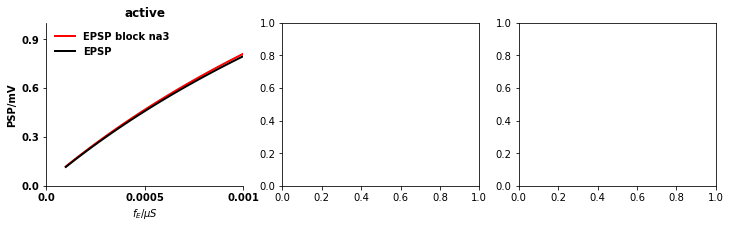

In [81]:
EPSP = np.loadtxt("EPSP_active_blockSKv3_1_fE.txt")
EPSP0 = np.loadtxt("EPSP_active_fE.txt")


fE = np.linspace(1e-4, 1e-3, 100)

fig, ax2 = plt.subplots(1,3, figsize = (12,3))
plot_curve(ax2[0], fE, EPSP, color='red', title='active', xlim=[0,1e-3], dx=5e-4, ylim=[0,1],dy=.3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'PSP/mV', label='EPSP block na3')
plot_curve(ax2[0], fE, EPSP0, color='black', title='active', xlim=[0,1e-3], dx=5e-4, ylim=[0,1],dy=.3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'PSP/mV', label='EPSP')

# plot_curve(ax2[0], fE, IPSP, color='blue', title='active', xlim=[0,1e-3],dx=5e-4,ylim=[0,1],dy=.3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'PSP/mV', label='IPSP')


# recovery of time constant

# single $f_E$

In [3]:
block = ['','na3','h','kadist','kaprox','kdrca1','nax','Ca_HVA','Ca_LVAst','Ih','Im','K_Pst','K_Tst',
         'Nap_Et2','NaTa_t','NaTs2_t','SK_E2','SKv3_1']
name = ['','gbar_na3','ghdbar_h','gkabar_kadist','gkabar_kaprox','gkdrbar_kdrca1','gbar_nax',
        'gCa_HVAbar_Ca_HVA','gCa_LVAstbar_Ca_LVAst','gIhbar_Ih','gImbar_Im','gK_Pstbar_K_Pst',
        'gK_Tstbar_K_Tst','gNap_Et2bar_Nap_Et2','gNaTa_tbar_NaTa_t','gNaTs2_tbar_NaTs2_t',
        'gSK_E2bar_SK_E2','gSKv3_1bar_SKv3_1']
para  = []
for i in range(len(block)):
    para.append([block[i],name[i]])


fE = 1e-3 

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
def time_constant_fitting_parallel(args,):
    para0, = args
    result_lambdas, y = time_constant_fitting(
        0.1, 0.1, fE, passive=False, E = True,loc=67, location ='dend', block=para0[0], name=para0[1])
    return result_lambdas, y 

with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(para0,) for para0 in para]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((len(block), 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :], y = result
    
# 替代字符串
filename_prefix = f"active_block_ion_dend67_fE1e3.txt"
np.savetxt(filename_prefix, estimated_lambdas)

/tmp/ipykernel_2276972/1806235200.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_2276972/1806235200.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)
/tmp/ipykernel_2276972/1806235200.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_2276972/1806235200.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)
/tmp/ipykernel_2276972/1806235200.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecate

In [10]:
result_lambdas, y = time_constant_fitting(
        0.1, 0.1, fE, passive=True, E = True, loc=67, location ='dend', block='', name='')
print(-1./result_lambdas)

[1.51620304 5.54146577]


/tmp/ipykernel_2276972/1806235200.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_2276972/1806235200.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)


In [9]:
filename_prefix = f"active_block_ion_dend67_fE1e3.txt"
estimated_lambdas = np.loadtxt(filename_prefix)
print(-1./estimated_lambdas[:,1])

[3.88116966 3.88116966 3.88116966 3.88116966 3.88116966 3.88116966
 3.88116966 3.88116967 3.88137784 5.52062566 3.88088691 3.88116052
 3.88115972 3.88118768 3.88171508 3.88116966 3.8801094  3.92477484]


# Vector $f_E$

In [16]:
block = ['','na3','h','kadist','kaprox','kdrca1','nax','Ca_HVA','Ca_LVAst','Ih','Im','K_Pst','K_Tst',
         'Nap_Et2','NaTa_t','NaTs2_t','SK_E2','SKv3_1']
name = ['','gbar_na3','ghdbar_h','gkabar_kadist','gkabar_kaprox','gkdrbar_kdrca1','gbar_nax',
        'gCa_HVAbar_Ca_HVA','gCa_LVAstbar_Ca_LVAst','gIhbar_Ih','gImbar_Im','gK_Pstbar_K_Pst',
        'gK_Tstbar_K_Tst','gNap_Et2bar_Nap_Et2','gNaTa_tbar_NaTa_t','gNaTs2_tbar_NaTs2_t',
        'gSK_E2bar_SK_E2','gSKv3_1bar_SKv3_1']


fE = np.linspace(1e-4, 1e-3, 50)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
for i in range(len(block)):
    block0 = block[i]
    name0 = name[i]
    def time_constant_fitting_parallel(args,):
        fE0, = args
        result_lambdas, y = time_constant_fitting(
            0.1, 0.1, fE0, passive=False, E = True, block=block0, name=name0)
        return result_lambdas, y 

    with Pool(num_processes) as pool:
        # Prepare arguments for parallel processing
        args_list = [(fE0,) for fE0 in fE]

        # Apply the function in parallel
        results = pool.map(time_constant_fitting_parallel, args_list)

    # Process the results
    estimated_lambdas = np.zeros((len(fE), 2))
    for i, result in enumerate(results):
        estimated_lambdas[i, :], y = result
        
    # 替代字符串
    filename_prefix = f"estimated_lambdas_active_block{block0}_fE1e4_1e3_50.txt"
    np.savetxt(filename_prefix, estimated_lambdas)

/tmp/ipykernel_1783531/1806235200.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_1783531/1806235200.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)
/tmp/ipykernel_1783531/1806235200.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_1783531/1806235200.py:98: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)
/tmp/ipykernel_1783531/1806235200.py:97: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecate

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


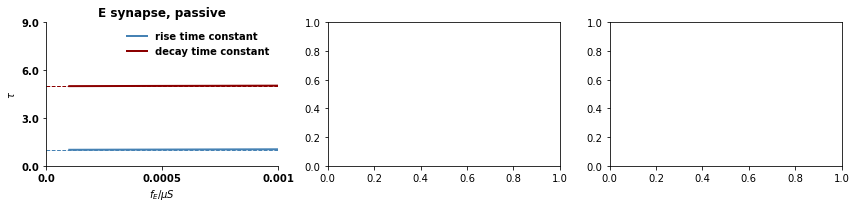

In [5]:
estimated_lambdas = np.loadtxt("estimated_lambdas_passive_apicloc34_fE.txt")


fE = np.linspace(1e-4, 1e-3, 50)
fig, ax2 = plt.subplots(1,3, figsize = (12,3))
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,0], color='steelblue', title='E synapse, passive', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='rise time constant')
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='decay time constant')
ax2[0].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
ax2[0].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
# plot_curve(ax2[1], fE, relative_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
# plot_curve(ax2[1], fE, relative_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
# plot_curve(ax2[2], fE, absolute_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'absolute error', label='')
# plot_curve(ax2[2], fE, absolute_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel ='absolute error', label='')
plt.tight_layout()


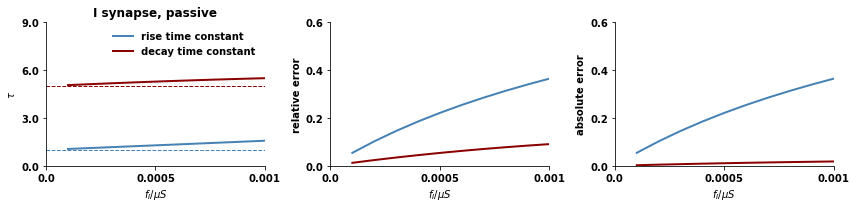

In [15]:
estimated_lambdas = np.loadtxt("estimated_lambdas_passive_fI.txt")
relative_error = np.loadtxt("relative_error_passive_fI.txt")
absolute_error = np.loadtxt("absolute_error_passive_fI.txt")

fE = np.linspace(1e-4, 1e-2, 100)
fig, ax2 = plt.subplots(1,3, figsize = (12,3))
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,0], color='steelblue', title='I synapse, passive', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = r'$\tau (ms)$', label='rise time constant')
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = r'$\tau (ms)$', label='decay time constant')
ax2[0].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
ax2[0].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
plot_curve(ax2[1], fE, relative_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = 'relative error', label='')
plot_curve(ax2[1], fE, relative_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = 'relative error', label='')
plot_curve(ax2[2], fE, absolute_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = 'absolute error', label='')
plot_curve(ax2[2], fE, absolute_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel ='absolute error', label='')
plt.tight_layout()


# active 

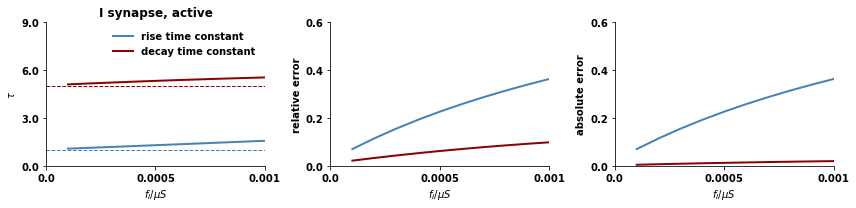

In [21]:
estimated_lambdas = np.loadtxt("estimated_lambdas_active_fI.txt")
relative_error = np.loadtxt("relative_error_active_fI.txt")
absolute_error = np.loadtxt("absolute_error_active_fI.txt")

fE = np.linspace(1e-4, 1e-2, 100)
fig, ax2 = plt.subplots(1,3, figsize = (12,3))
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,0], color='steelblue', title='I synapse, active', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = r'$\tau (ms)$', label='rise time constant')
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = r'$\tau (ms)$', label='decay time constant')
ax2[0].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
ax2[0].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
plot_curve(ax2[1], fE, relative_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = 'relative error', label='')
plot_curve(ax2[1], fE, relative_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = 'relative error', label='')
plot_curve(ax2[2], fE, absolute_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel = 'absolute error', label='')
plot_curve(ax2[2], fE, absolute_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{I}/\mu S$', ylabel ='absolute error', label='')
plt.tight_layout()


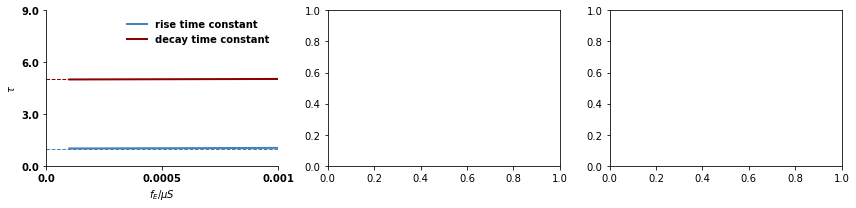

In [8]:
estimated_lambdas = np.loadtxt("estimated_lambdas_passive_apicloc34_fE.txt")


fE = np.linspace(1e-4, 1e-3, 50)
fig, ax2 = plt.subplots(1,3, figsize = (12,3))
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,0], color='steelblue',
           title='', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='rise time constant')
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,1], color='darkred', 
           title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='decay time constant')
ax2[0].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
ax2[0].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
# plot_curve(ax2[1], fE, relative_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
# plot_curve(ax2[1], fE, relative_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
# plot_curve(ax2[2], fE, absolute_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'absolute error', label='')
# plot_curve(ax2[2], fE, absolute_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel ='absolute error', label='')
plt.tight_layout()


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

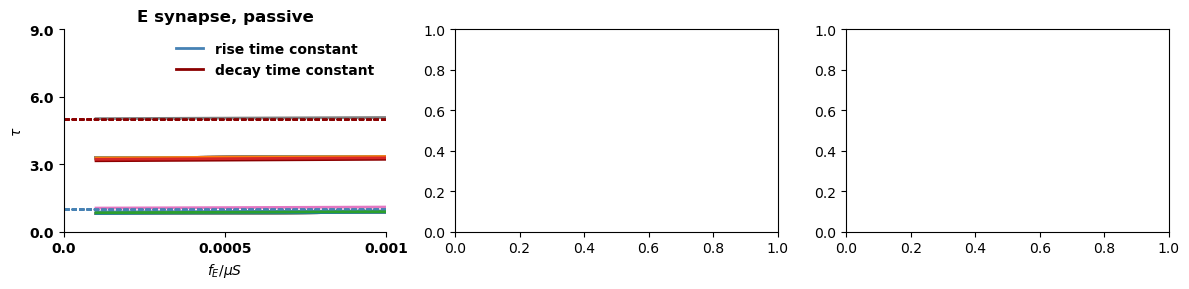

In [22]:
estimated_lambdas = np.loadtxt("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/estimated_lambdas_active_fE.txt")
# relative_error = np.loadtxt("relative_error_active_fE.txt")
# absolute_error = np.loadtxt("absolute_error_active_fE.txt")
block = ['na3','h','kadist','kaprox','kdrca1','nax','Ca_HVA','Ca_LVAst','Ih','Im','K_Pst','K_Tst',
         'Nap_Et2','NaTa_t','NaTs2_t','SK_E2','SKv3_1']
name = ['gbar_na3','ghdbar_h','gkabar_kadist','gkabar_kaprox','gkdrbar_kdrca1','gbar_nax',
        'gCa_HVAbar_Ca_HVA','gCa_LVAstbar_Ca_LVAst','gIhbar_Ih','gImbar_Im','gK_Pstbar_K_Pst',
        'gK_Tstbar_K_Tst','gNap_Et2bar_Nap_Et2','gNaTa_tbar_NaTa_t','gNaTs2_tbar_NaTs2_t',
        'gSK_E2bar_SK_E2','gSKv3_1bar_SKv3_1']

fE = np.linspace(1e-4, 1e-2, 50)
fig, ax2 = plt.subplots(1,3, figsize = (12,3))
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,0], color='steelblue', title='E synapse, passive', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='rise time constant')
plot_curve(ax2[0], fE, -1./estimated_lambdas[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='decay time constant')
ax2[0].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
ax2[0].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
# plot_curve(ax2[1], fE, relative_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
# plot_curve(ax2[1], fE, relative_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
# plot_curve(ax2[2], fE, absolute_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'absolute error', label='')
# plot_curve(ax2[2], fE, absolute_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel ='absolute error', label='')
plt.tight_layout()

for i in range(len(block)):
        block0 = block[i]
        filename_prefix = f"estimated_lambdas_active_block{block0}_fE.txt"
        estimated_lambdas_active_block_fE = np.loadtxt("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/"+filename_prefix)
        # print(np.shape(estimated_lambdas_active_block_fE))
        # filename_prefix = f"relative_error_active_block{block0}_fE.txt"
        # relative_error_active_block_fE=np.loadtxt(filename_prefix)
        # filename_prefix = f"absolute_error_active_block{block0}_fE.txt"
        # absolute_error_active_block_fE=np.loadtxt("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/"+filename_prefix)
        fE = np.linspace(1e-4, 1e-2, np.shape(estimated_lambdas_active_block_fE)[0])
        plot_curve(ax2[0], fE, -1./estimated_lambdas_active_block_fE[:,0], color='', title='E synapse, passive', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='')
        plot_curve(ax2[0], fE, -1./estimated_lambdas_active_block_fE[:,1], color='', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='')
        ax2[0].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
        ax2[0].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
        # plot_curve(ax2[1], fE, relative_error_active_block_fE[:,0], color='', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
        # plot_curve(ax2[1], fE, relative_error_active_block_fE[:,1], color='', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
        # plot_curve(ax2[2], fE, absolute_error_active_block_fE[:,0], color='', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'absolute error', label='')
        # plot_curve(ax2[2], fE, absolute_error_active_block_fE[:,1], color='', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel ='absolute error', label='')
        # plt.legend(fontsize=6)
        # 添加 legend，并设置位置

plt.savefig("realistic_active_block_ion_chanel.eps", format='eps')    

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

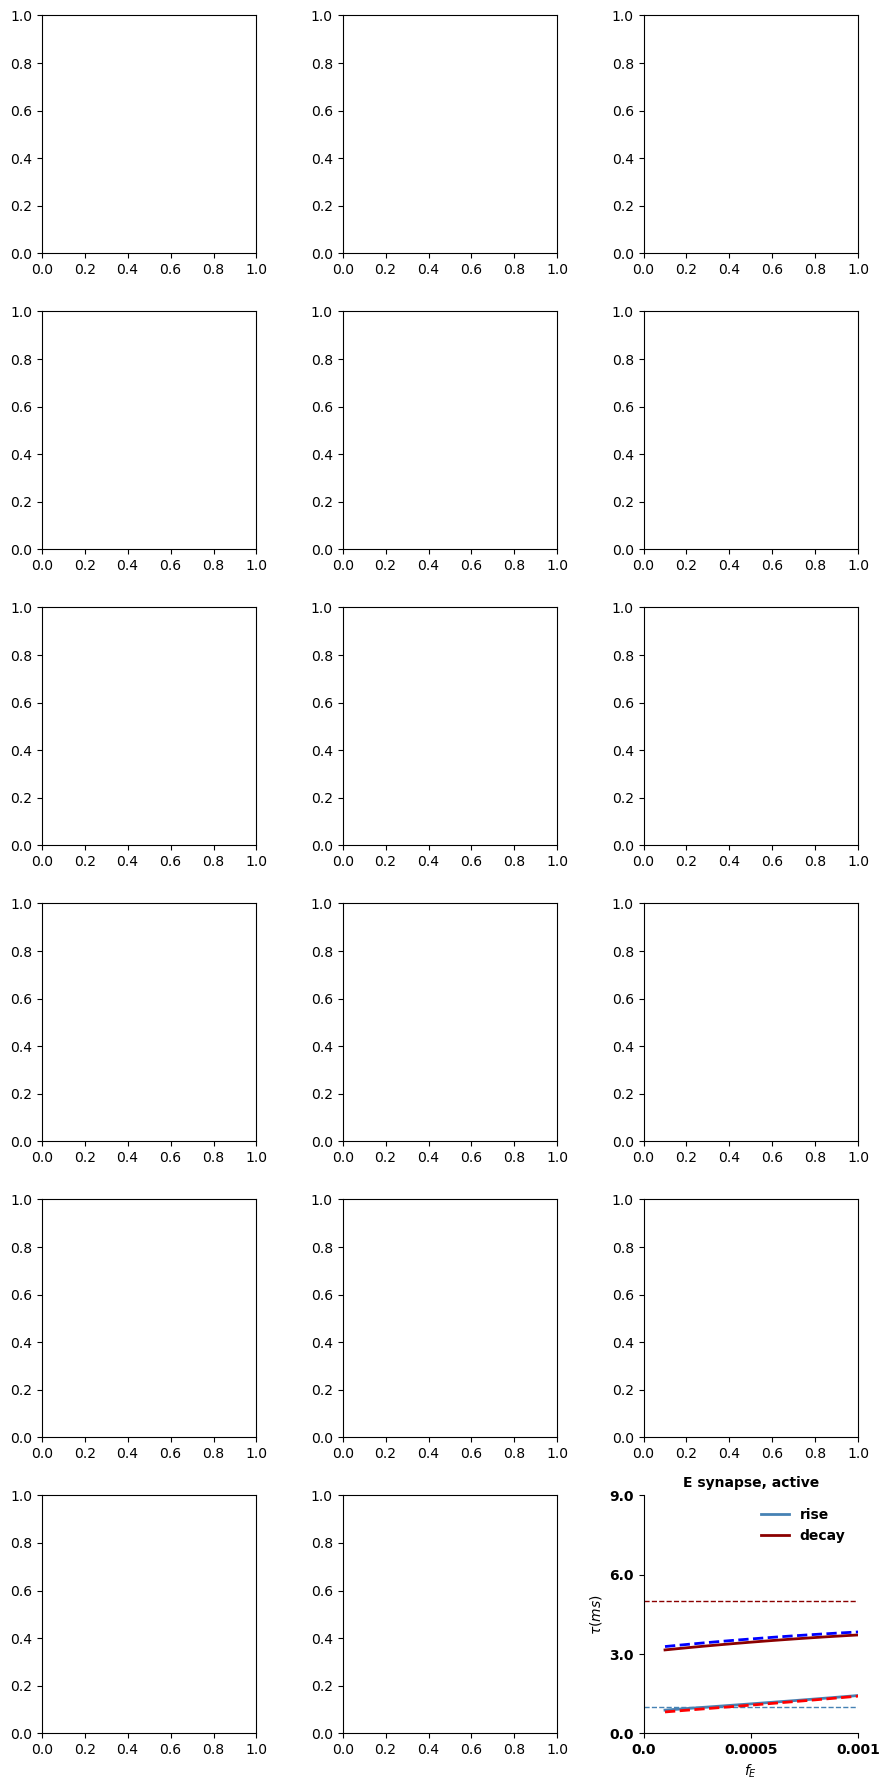

In [61]:
estimated_lambdas = np.loadtxt("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/"+"estimated_lambdas_active_fE.txt")
block = ['na3','h','kadist','kaprox','kdrca1','nax','Ca_HVA','Ca_LVAst','Ih','Im','K_Pst','K_Tst',
         'Nap_Et2','NaTa_t','NaTs2_t','SK_E2','SKv3_1']
name = ['gbar_na3','ghdbar_h','gkabar_kadist','gkabar_kaprox','gkdrbar_kdrca1','gbar_nax',
        'gCa_HVAbar_Ca_HVA','gCa_LVAstbar_Ca_LVAst','gIhbar_Ih','gImbar_Im','gK_Pstbar_K_Pst',
        'gK_Tstbar_K_Tst','gNap_Et2bar_Nap_Et2','gNaTa_tbar_NaTa_t','gNaTs2_tbar_NaTs2_t',
        'gSK_E2bar_SK_E2','gSKv3_1bar_SKv3_1']
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
fontsize = 10

fE = np.linspace(1e-4, 1e-3, 50)
fig, ax2 = plt.subplots(6,3, figsize = (9,18))
plot_curve(ax2[5,2], fE, -1./estimated_lambdas[:,0], color='steelblue', title='E synapse, active', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='rise', fontsize = fontsize)
plot_curve(ax2[5,2], fE, -1./estimated_lambdas[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='decay', fontsize = fontsize)

ax2[5,2].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
ax2[5,2].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
filename_prefix = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/estimated_lambdas_active_blockna3_fE.txt"
estimated_lambdas_active_block_fE = np.loadtxt(filename_prefix)
fE = np.linspace(1e-4, 1e-3, np.shape(estimated_lambdas_active_block_fE)[0])
plot_curve(ax2[5,2], fE, -1./estimated_lambdas_active_block_fE[:,0], color='red', linestyle='--', title='', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='', fontsize = fontsize)
plot_curve(ax2[5,2], fE, -1./estimated_lambdas_active_block_fE[:,1], color='blue', linestyle='--', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='', fontsize = fontsize)
plt.tight_layout()

# for i in range(len(block)):
#         block0 = block[i]
#         n_row  = int(i/3)
#         n_col = (i)%3
#         fE = np.linspace(1e-4, 1e-2, 50)
#         plot_curve(ax2[n_row,n_col], fE, -1./estimated_lambdas[:,0], color='steelblue', title='E synapse, active', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='', fontsize = fontsize)
#         plot_curve(ax2[n_row,n_col], fE, -1./estimated_lambdas[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='',fontsize = fontsize)
#         ax2[n_row,n_col].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
#         ax2[n_row,n_col].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
#         plt.tight_layout()
        
#         filename_prefix = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/"+ f"estimated_lambdas_active_block{block0}_fE.txt"
#         estimated_lambdas_active_block_fE = np.loadtxt(filename_prefix)
#         fE = np.linspace(1e-4, 1e-2, np.shape(estimated_lambdas_active_block_fE)[0])
#         plot_curve(ax2[n_row,n_col], fE, -1./estimated_lambdas_active_block_fE[:,0], color='red', linestyle='--', title='block'+block0, xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='', fontsize = fontsize)
#         plot_curve(ax2[n_row,n_col], fE, -1./estimated_lambdas_active_block_fE[:,1], color='blue', linestyle='--', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='', fontsize = fontsize)
#         ax2[n_row,n_col].axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
#         ax2[n_row,n_col].axhline(y=5, color='darkred', linestyle='--', linewidth=1)
#         savefilename_prefix = f"realistic_active_block{block0}.png"
#         # plt.savefig(savefilename_prefix, format='png') 

# plt.savefig("realistic_active_block_ion_chanel.eps", format='eps')    

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

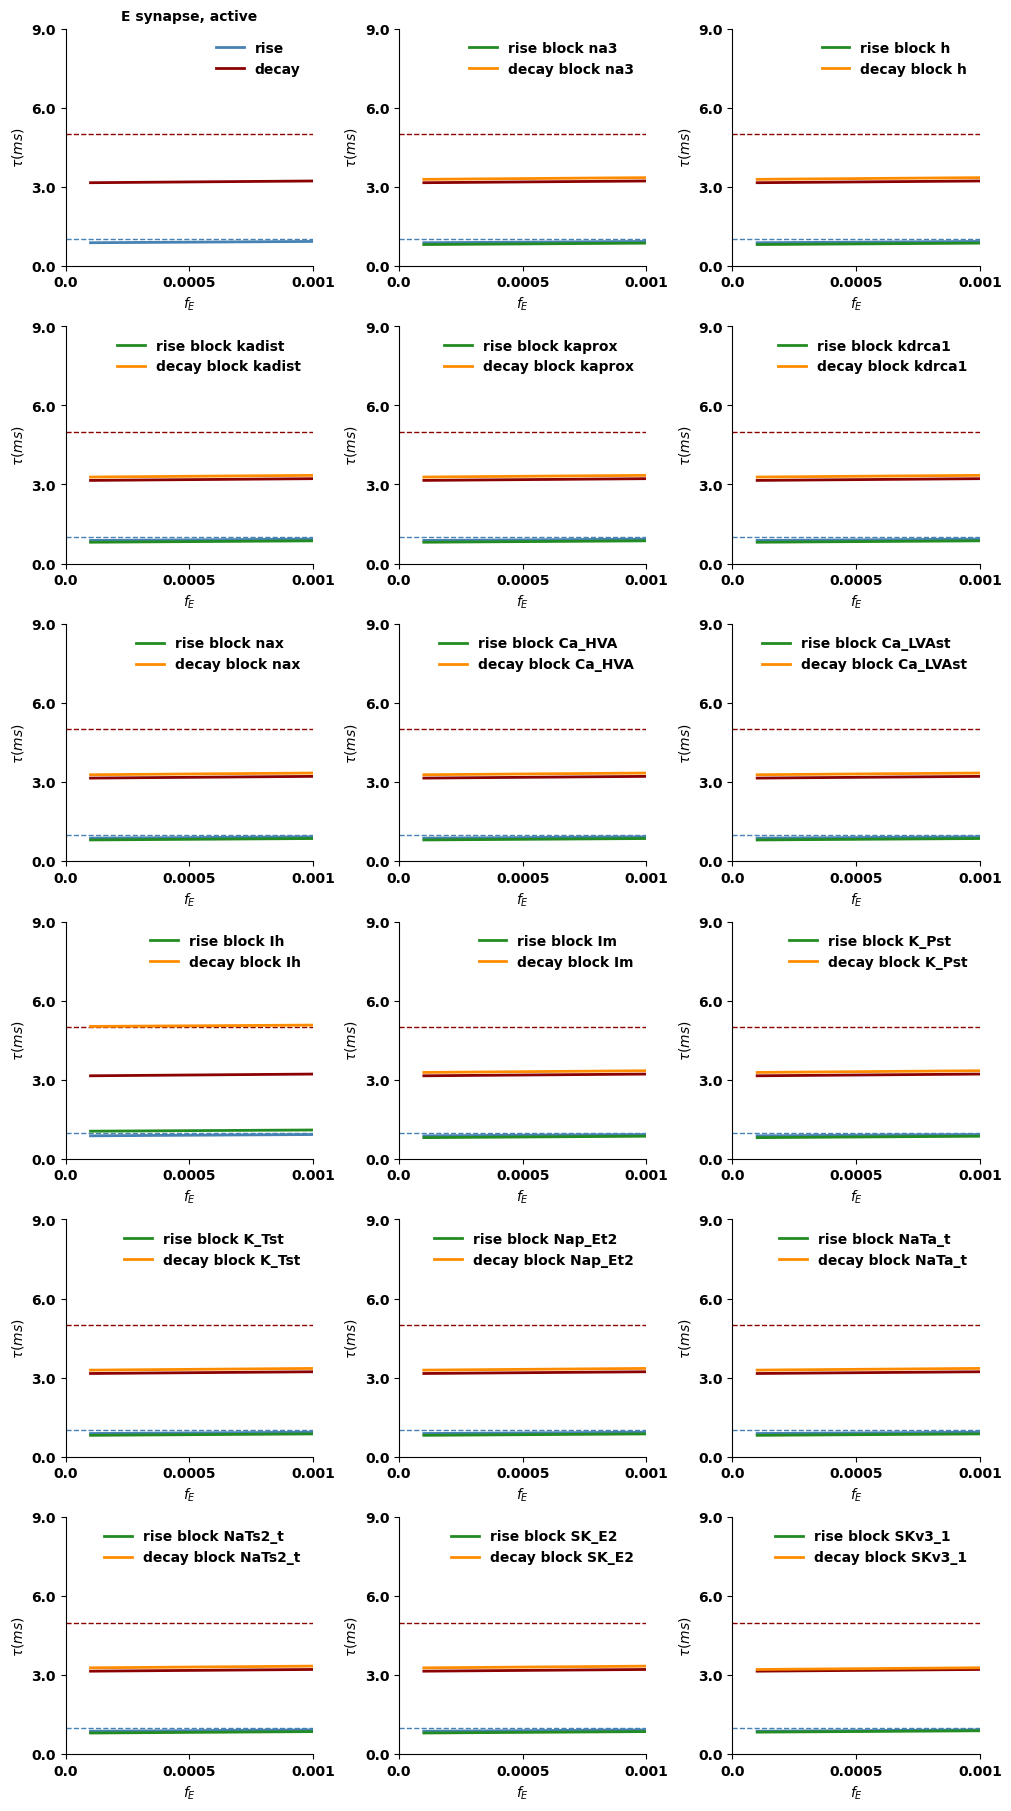

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
estimated_lambdas = np.loadtxt("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/"+"estimated_lambdas_active_fE.txt")

# 定义阻断通道
block = ['na3','h','kadist','kaprox','kdrca1','nax','Ca_HVA','Ca_LVAst','Ih','Im','K_Pst','K_Tst',
         'Nap_Et2','NaTa_t','NaTs2_t','SK_E2','SKv3_1']

# 设定字体
fontsize = 10
font2 = {'family': 'Times New Roman', 'weight': 'bold', 'size': fontsize}

# 创建子图
fig, axes = plt.subplots(6, 3, figsize=(10, 18), constrained_layout=True)
axes = axes.flatten()  # 将 6x3 的 axes 数组展平成 1D 数组

# 定义颜色
active_color_rise = 'steelblue'
active_color_decay = 'darkred'
block_color_rise = '#228B22'  # Forest Green
block_color_decay = '#FF8C00'  # Dark Orange


# 先绘制原始图 (E synapse, active)，放到第一个子图
fE = np.linspace(1e-4, 1e-2, 50)
plot_curve(axes[0], fE, -1./estimated_lambdas[:,0], color=active_color_rise, title='E synapse, active', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='rise', fontsize = fontsize)
plot_curve(axes[0], fE, -1./estimated_lambdas[:,1], color=active_color_decay, title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='decay', fontsize = fontsize)
axes[0].axhline(y=1, color=active_color_rise, linestyle='--', linewidth=1)
axes[0].axhline(y=5, color=active_color_decay, linestyle='--', linewidth=1)


# 依次绘制不同的通道阻断结果
for i, block0 in enumerate(block):
    fE = np.linspace(1e-4, 1e-2, 50)
    
    # 绘制 Active 结果
    plot_curve(axes[i+1], fE, -1./estimated_lambdas[:,0], color=active_color_rise, title='', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='', fontsize = fontsize)
    plot_curve(axes[i+1], fE, -1./estimated_lambdas[:,1], color=active_color_decay, title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='', fontsize = fontsize)
    axes[i+1].axhline(y=1, color=active_color_rise, linestyle='--', linewidth=1)
    axes[i+1].axhline(y=5, color=active_color_decay, linestyle='--', linewidth=1)

    # 读取 Block 结果
    filename_prefix = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/"+ f"estimated_lambdas_active_block{block0}_fE.txt"
    estimated_lambdas_block = np.loadtxt(filename_prefix)

    # 绘制 Block 结果
    fE = np.linspace(1e-4, 1e-2, np.shape(estimated_lambdas_block)[0])
    plot_curve(axes[i+1], fE, -1./estimated_lambdas_block[:,0], color=block_color_rise,  title='', xlim=[0,1e-3],ylim=[0,9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='rise block ' + block0, fontsize = fontsize)
    plot_curve(axes[i+1], fE, -1./estimated_lambdas_block[:,1], color=block_color_decay, title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = r'$\tau (ms)$', label='decay block ' + block0, fontsize = fontsize)
        
    
# 保存图片
plt.savefig("realistic_active_block_ion_channel.eps", dpi=300, bbox_inches='tight')
plt.show()


# EPSP

In [5]:
def measure_EPSP(run_dt, fE, passive=False, E = True, loc=58,
                          block='',name= '', location ='dend'):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    recv = h.Vector()
    recv.record(L5PC.soma[0](0.5)._ref_v)
    t = h.Vector().record(h._ref_t)
    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    # for sec in h.allsec():
    #     if h.ismembrane("SKv3_1",sec=sec):
    #         sec.gSKv3_1bar_SKv3_1 = 0.766
             
    # Set simulation parameters
    h.dt = run_dt
    h.tstop = 200.
    h.v_init = -77.
    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()

    # attach it to a synapse
    if location == 'dend':
        syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))    
        synv = h.Vector().record(L5PC.dend[int(loc)](0.9)._ref_v)

    if location == 'apic':
        syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
        synv = h.Vector().record(L5PC.apic[int(loc)](0.9)._ref_v)
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        syn.e = 0.  # mV for E input and -100 for I input
    else: 
        syn.e = -100.
    
        
    stim.number = 1
    stim.start = 100.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = fE  # uS

    h.t = 0
    h.finitialize(h.v_init)
    h.fcurrent()

    while h.t < h.tstop:
        h.fadvance()
    
    t0 = t.to_python()
    recv0 = recv.to_python()
    synv0 = synv.to_python()
    EPSP_soma = np.max(recv0[1000:]) - np.min(recv0[1000:])
    EPSP_dend = np.max(synv0[1000:]) - np.min(synv0[1000:])
    return EPSP_soma, EPSP_dend


# fE

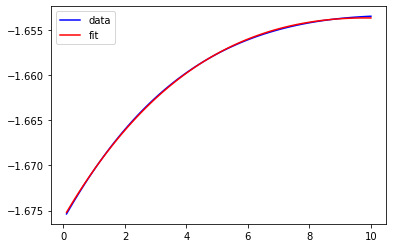

In [22]:
estimated_lambda, y  = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = False, E = True, block='', name='', plot=True,
        loc=37, location='apic', setIh=True, gIhbar_Ih = 0.0002/20.)

In [23]:
estimated_lambda

array([-0.08764944, -0.0831227 ])

In [24]:
-1./estimated_lambda

array([11.40908625, 12.03040814])

In [17]:
x = np.arange(0.1, 10.1, 0.1) 
# Calculate integrals
iy1 = cumtrapz(y, x, initial=0)
iy2 = cumtrapz(iy1, x, initial=0)


# Get exponentials lambdas
Y = np.column_stack((iy1, iy2,  x**2, x, np.ones_like(x)))
A = pinv(Y) @ y
print(A[0]**2 + 4*A[1])

if A[0]**2 + 4*A[1]<0:
    # 定义目标函数
    def objective(t):
        return np.linalg.norm(Y @ t - y)

    # 定义约束函数
    def constraint(t):
        return t[0]**2 + 4*t[1]

    # 初始猜测
    x0 = np.array([0, 0, 0, 0, 0])

    # 定义约束
    cons = {'type': 'ineq', 'fun': constraint}

    # 设置迭代次数
    options = {'maxiter': 10000}  # 将最大迭代次数设置为1000

    # 使用scipy.optimize.minimize求解问题
    solution = minimize(objective, x0, constraints=cons, options=options)
    A = solution.x


lambdas = eig(np.array([[A[0], A[1]], [1, 0]]))[0]
print("Lambdas:", lambdas)
print(A[0]**2 + 4*A[1])
# Get exponentials multipliers
X = np.column_stack((np.ones_like(x), np.exp(lambdas[0] * x), np.exp(lambdas[1] * x)))
P = pinv(X) @ y

-0.04043480257626467
Lambdas: [-0.03470653  0.00583305]
0.001643457573151053


In [14]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    fE0, = args
    estimated_lambda, y  = time_constant_fitting(
        0.1, 0.1, fE0, passive = True, E = False, block='', name='', 
        loc=34, location='apic', setIh=False, gIhbar_Ih = 0.0002/10.)
     
    return estimated_lambda

# fE = np.linspace(1e-4, 5e-3, 50) # for E
fE = np.linspace(1e-4, 2e-2, 50)   # for I

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(fE0,) for fE0 in fE]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((len(fE), 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
    
np.savetxt("estimated_lambdas_passive_apicloc34_fI.txt", estimated_lambdas)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


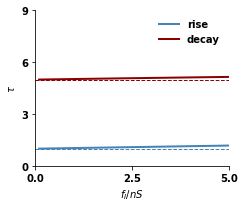

In [21]:
estimated_lambdas = np.loadtxt("estimated_lambdas_passive_apicloc34_fE.txt")

fE = np.linspace(1e-4, 5e-3, 50)*1e3 # for E
# fE = np.linspace(1e-4, 2e-2, 50)*1e3   # for I
fig, ax2 = plt.subplots(1,1, figsize = (3.5,3))
plot_curve(ax2, fE, -1./estimated_lambdas[:,0], color='steelblue',
        title='', xlim=[0,5],ylim=[0,9],alpha = 1.0, 
        xlabel=r'$f_{E}/nS$', ylabel = r'$\tau (ms)$', label='rise')
plot_curve(ax2, fE, -1./estimated_lambdas[:,1], color='darkred', title='',
        xlim=[0,5], dx=2.5, ylim=[0,9], dy=3, alpha = 1.0, xlabel=r'$f_{I}/nS$',
        ylabel = r'$\tau (ms)$', label='decay', ynum_decimals=0.)
ax2.axhline(y=1, color='steelblue', linestyle='--', linewidth=1)
ax2.axhline(y=5, color='darkred', linestyle='--', linewidth=1)
# plot_curve(ax2[1], fE, relative_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
# plot_curve(ax2[1], fE, relative_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'relative error', label='')
# plot_curve(ax2[2], fE, absolute_error[:,0], color='steelblue', title='', xlim=[0,1e-3],ylim=[0,0.9],alpha = 1.0, xlabel=r'$f_{E}$', ylabel = 'absolute error', label='')
# plot_curve(ax2[2], fE, absolute_error[:,1], color='darkred', title='', xlim=[0,1e-3], dx=5e-4, ylim=[0,0.6], dy=0.2, alpha = 1.0, xlabel=r'$f_{E}$', ylabel ='absolute error', label='')
plt.tight_layout()
plt.savefig("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/figure/figrue2/time_con_passive_Eapic34.eps", format='eps', dpi=300)


In [8]:
# Your existing functions and code
def measure_EPSP_parallel(args,):
    fE0, = args
    EPSP_soma, EPSP_dend  = measure_EPSP(
        0.1, fE0, passive = True, E = True, block='', name='', 
        loc=34, location='apic')
     
    return EPSP_soma, EPSP_dend

fE = np.linspace(1e-4, 1e-3, 50)


# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(fE0,) for fE0 in fE]

    # Apply the function in parallel
    results = pool.map(measure_EPSP_parallel, args_list)

# Process the results
EPSP = np.zeros((len(fE), 2))
for i, result in enumerate(results):
    EPSP[i, :] = result
    
np.savetxt("EPSP_active_apic36_fE.txt", EPSP)
# np.savetxt("EPSP_active_apicloc109_fE1e4.txt", EPSP)

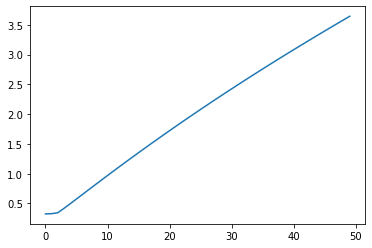

In [9]:
EPSP = np.loadtxt('EPSP_active_apic36_fE.txt')
np.shape(EPSP)
EPSP_soma = EPSP[:,0]
plt.plot(EPSP_soma)

# location

In [3]:
EPSP_soma, EPSP_dend = measure_EPSP(0.1, 1e-3, passive=False, E = True, 
                                    loc=83, block='',name= '', location ='dend')
print(EPSP_soma, EPSP_dend)

1.2913227955282451 5.510249375002047


In [10]:
# Your existing functions and code
def measure_EPSP_parallel(args,):
    loc0, = args
    EPSP_soma, EPSP_dend  = measure_EPSP(
        0.1, 1e-3, passive = False, E = True, block='', name='', 
        loc=loc0, location='dend')
     
    return EPSP_soma, EPSP_dend

loc = np.arange(0, 84, 1)
loc.astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(measure_EPSP_parallel, args_list)

# Process the results
EPSP = np.zeros((len(loc), 2))
for i, result in enumerate(results):
    EPSP[i, :] = result
    
np.savetxt("EPSP_active_dendloc84.txt", EPSP)
# np.savetxt("EPSP_active_apicloc109_fE1e4.txt", EPSP)

In [ ]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    estimated_lambda, y  = time_constant_fitting(
        0.1, 0.1, 1e-3, passive = False, E = False, block='', name='', 
        loc=loc0, location='apic', setIh = True, gIhbar_Ih = 0.0002/20.)
     
    return estimated_lambda

loc = np.arange(0, 109, 1)
loc.astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((len(loc), 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
    
# np.savetxt("estimated_lambdas_active_apicloc109_fI1e3_gIhbar_Ih0_05.txt", estimated_lambdas)
np.savetxt("estimated_lambdas_active_apicloc109_fI1e3_gIhbar_Ih0_05.txt", estimated_lambdas)


(0.0, 10.0)

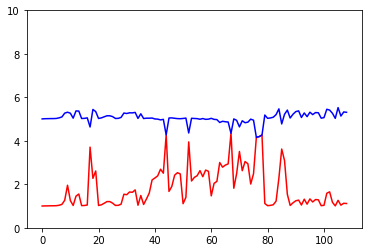

In [10]:
estimated_lambdas_apic= np.loadtxt("estimated_lambdas_passive_apicloc109.txt")
plt.plot(-1./estimated_lambdas_apic[:,0],'r')
plt.plot(-1./estimated_lambdas_apic[:,1],'b')
plt.ylim([0,10])

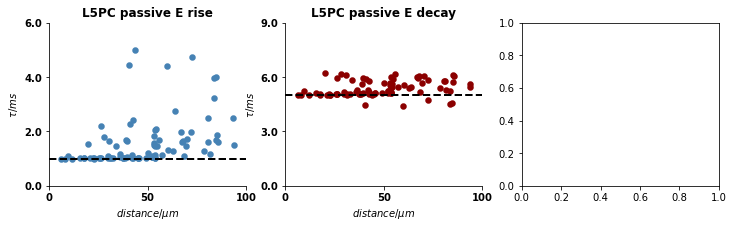

In [124]:
L5PC = h.L5PCtemplate(morphologyFilename)
x_soma = (L5PC.soma[0].x3d(0)+L5PC.soma[0].x3d(1))*0.5
y_soma = (L5PC.soma[0].y3d(0)+L5PC.soma[0].y3d(1))*0.5
z_soma = (L5PC.soma[0].z3d(0)+L5PC.soma[0].z3d(1))*0.5
loc = np.arange(0, 84, 1)
loc.astype(int)
distance=[]
gbar_Ih=[]
diam=[]
L=[]
for i in range(len(loc)):
    if h.ismembrane("Ih",sec = L5PC.dend[i]):
        gbar_Ih0 = L5PC.dend[i].gIhbar_Ih
    else:
        gbar_Ih0 = 0
    gbar_Ih.append(gbar_Ih0)
    diam.append(L5PC.dend[i].diam)
    L.append(L5PC.dend[i].L)
    x_dend = (L5PC.dend[loc[i]].x3d(0)+L5PC.dend[loc[i]].x3d(1))*0.5
    y_dend = (L5PC.dend[loc[i]].y3d(0)+L5PC.dend[loc[i]].y3d(1))*0.5
    z_dend = (L5PC.dend[loc[i]].z3d(0)+L5PC.dend[loc[i]].z3d(1))*0.5
    dist = np.sqrt((x_soma-x_dend)**2+(y_soma-y_dend)**2+(z_soma-z_dend)**2)
    distance.append(dist)
distance = np.array(distance)
estimated_lambdas = np.loadtxt("estimated_lambdas_passive_loc083.txt")
estimated_rise = -1./estimated_lambdas[:,0]
estimated_decay = -1./estimated_lambdas[:,1]
fig, ax2 = plt.subplots(1,3, figsize = (12,3.))
plot_curve(ax2[0], distance, estimated_rise, color='steelblue',
           title='L5PC passive E rise' , xlim=[0,100],dx=50, ylim=[0,6],dy=2, 
           alpha = 1.0, xlabel=r'$distance/\mu m$', ylabel = r'$\tau/ms$', label='',
          nonscatter=False, s0=20)
plot_curve(ax2[1], distance, estimated_decay, color='darkred',
           title='L5PC passive E decay' , xlim=[0,100], dx=50, ylim=[0,9],dy=3, 
           alpha = 1.0,xlabel=r'$distance/\mu m$', ylabel = r'$\tau/ms$', label='',
          nonscatter=False, s0=20)
ax2[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
ax2[1].axhline(y=5, color='black', linestyle='--', linewidth=2)

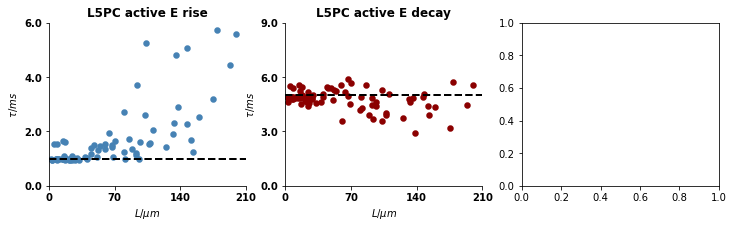

In [92]:
fig, ax2 = plt.subplots(1,3, figsize = (12,3.))
plot_curve(ax2[0], L, estimated_rise, color='steelblue',
           title='L5PC active E rise' , xlim=[0,210],dx=0, ylim=[0,6],dy=2, 
           alpha = 1.0, xlabel=r'$L /\mu m$', ylabel = r'$\tau/ms$', label='',
          nonscatter=False, s0=20)
plot_curve(ax2[1], L, estimated_decay, color='darkred',
           title='L5PC active E decay' , xlim=[0,210], dx=70, ylim=[0,9],dy=3, 
           alpha = 1.0,xlabel=r'$L /\mu m$', ylabel = r'$\tau/ms$', label='',
          nonscatter=False, s0=20)
ax2[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
ax2[1].axhline(y=5, color='black', linestyle='--', linewidth=2)

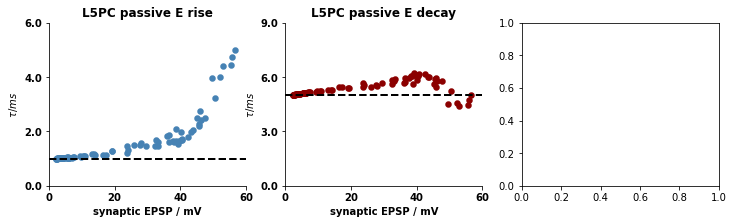

In [125]:
estimated_lambdas = np.loadtxt("estimated_lambdas_passive_loc083.txt")
estimated_rise = -1./estimated_lambdas[:,0]
estimated_decay = -1./estimated_lambdas[:,1]
EPSP = np.loadtxt("EPSP_passive_loc083.txt")
fig, ax2 = plt.subplots(1,3, figsize = (12,3.))
plot_curve(ax2[0], EPSP[:,1], estimated_rise, color='steelblue',
           title='L5PC passive E rise' , xlim=[0,60],dx=20, ylim=[0,6],dy=2, 
           alpha = 1.0, xlabel='synaptic EPSP / mV', ylabel = r'$\tau/ms$', label='',
          nonscatter=False, s0=20)
plot_curve(ax2[1], EPSP[:,1], estimated_decay, color='darkred',
           title='L5PC passive E decay' , xlim=[0,60], dx=20, ylim=[0,9],dy=3, 
           alpha = 1.0,xlabel='synaptic EPSP / mV', ylabel = r'$\tau/ms$', label='',
          nonscatter=False, s0=20)
ax2[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
ax2[1].axhline(y=5, color='black', linestyle='--', linewidth=2)

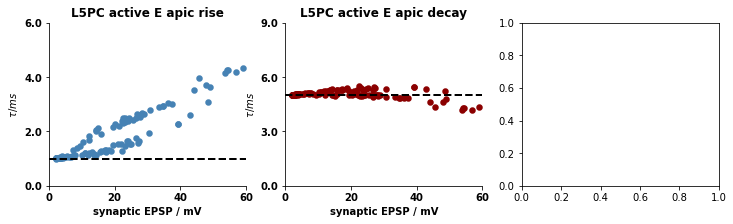

In [13]:
estimated_lambdas = np.loadtxt("estimated_lambdas_passive_apicloc109.txt")
estimated_rise = -1./estimated_lambdas[:,0]
estimated_decay = -1./estimated_lambdas[:,1]
EPSP = np.loadtxt("EPSP_passive_apicloc109.txt")
fig, ax2 = plt.subplots(1,3, figsize = (12,3.))
plot_curve(ax2[0], EPSP[:,1], estimated_rise, color='steelblue',
           title='L5PC active E apic rise' , xlim=[0,60],dx=20, ylim=[0,6],dy=2, 
           alpha = 1.0, xlabel='synaptic EPSP / mV', ylabel = r'$\tau/ms$', label='',
          nonscatter=False, s0=20)
plot_curve(ax2[1], EPSP[:,1], estimated_decay, color='darkred',
           title='L5PC active E apic decay' , xlim=[0,60], dx=20, ylim=[0,9],dy=3, 
           alpha = 1.0,xlabel='synaptic EPSP / mV', ylabel = r'$\tau/ms$', label='',
          nonscatter=False, s0=20)
ax2[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
ax2[1].axhline(y=5, color='black', linestyle='--', linewidth=2)

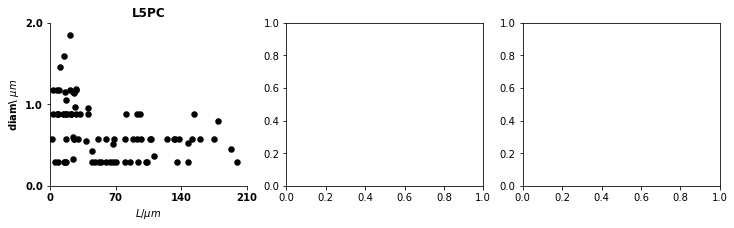

In [96]:
fig, ax2 = plt.subplots(1,3, figsize = (12,3.))
plot_curve(ax2[0], L, diam, color='black',
           title='L5PC' , xlim=[0,210],dx=70, ylim=[0,2],dy=1, 
           alpha = 1.0, xlabel=r'$L /\mu m$', ylabel = 'diam\ '+r'$\mu m$', label='',
          nonscatter=False, s0=20)

In [81]:
L5PC = h.L5PCtemplate(morphologyFilename)
# dir(L5PC.dend[82])
L5PC.dend[83].diam
# h.topology()

0.8799999952316285

In [135]:
estimated_lambdas_passive = np.loadtxt('/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/data/estimated_lambdas_passive_fE.txt')
estimated_lambdas_loc = np.loadtxt("estimated_lambdas_passive_loc083.txt")
print(-1./estimated_lambdas_passive[-1,:])
print(-1./estimated_lambdas_loc[58,:])


[1.57380921 5.49875476]
[1.57380921 5.49875476]


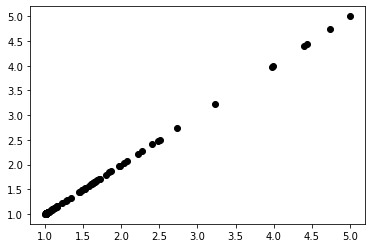

In [129]:
estimated_lambdas = np.loadtxt("estimated_lambdas_passive_loc083.txt")
estimated_rise = -1./estimated_lambdas[:,0]
estimated_decay = -1./estimated_lambdas[:,1]
estimated_lambdas_active = np.loadtxt("estimated_lambdas_active_loc083.txt")
estimated_rise_active = -1./estimated_lambdas[:,0]
estimated_decay_active = -1./estimated_lambdas[:,1]
plt.scatter(estimated_rise, estimated_rise_active, color='black', label='passive')

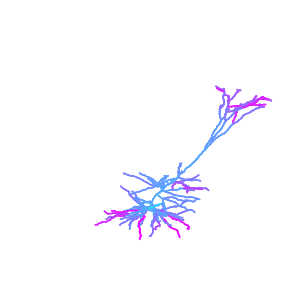

In [36]:
# from neuron import h
from matplotlib import pyplot, cm
estimated_lambdas_apic = np.loadtxt("estimated_lambdas_passive_apicloc109.txt")
estimated_lambdas_apic_rise = -1./estimated_lambdas_apic[:,0]
estimated_lambdas_apic_decay = -1./estimated_lambdas_apic[:,1]
 
estimated_lambdas_dend = np.loadtxt("estimated_lambdas_passive_dendloc84.txt")
estimated_lambdas_dend_rise = -1./estimated_lambdas_dend[:,0]
estimated_lambdas_dend_decay = -1./estimated_lambdas_dend[:,1]

L5PC = h.L5PCtemplate(morphologyFilename)
L5PC.soma[0].diam = 100
for i in range(109):
  L5PC.apic[i].v = estimated_lambdas_apic_rise[i]
  
for i in range(84):
  L5PC.dend[i].v = estimated_lambdas_dend_rise[i]
L5PC.soma[0].v=0.
L5PC.axon[0].v=0.
L5PC.axon[1].v=0.

v_vals = [seg.v for sec in h.allsec() for seg in sec]
      
ps = h.PlotShape(False)  # False tells h.PlotShape not to use NEURON's gui
ps.variable('v')
ps.scale(min(v_vals), max(v_vals))
ax = ps.plot(pyplot, cmap=cm.cool)
ps.show(1)
# ps.view(azimuth=90, elevation=90)
# ps.view(mleft, mbottom, mwidth, mheight, sleft, stop, swidth, sheight)



  # 设置坐标轴范围
ax.set_xlim([-700, 0])  # 替换 xmin 和 xmax 为所需的 x 范围
ax.set_ylim([500, 1400])  # 替换 ymin 和 ymax 为所需的 y 范围
ax.set_zlim([-1000, 00])  # 替换 zmin 和 zmax 为所需的 z 范围
# ax.set_title('Ih',fontsize=12,weight='bold')
# 关闭网格
ax.grid(False)
# 关闭坐标轴
ax.axis('off')
# 保存为 EPS 格式
plt.savefig('neuron_fE1e-3.eps', format='eps')

In [18]:
import plotly
import plotly.graph_objects as go
from neuron import h, gui
from neuron.units import mV, ms
import numpy as np
import matplotlib.colors as mcolors
from matplotlib import cm
L5PC = h.L5PCtemplate(morphologyFilename)
estimated_lambdas_apic = np.loadtxt("estimated_lambdas_passive_apicloc109.txt")
estimated_lambdas_apic_rise = -1./estimated_lambdas_apic[:,0]
estimated_lambdas_apic_decay = -1./estimated_lambdas_apic[:,1]
 
estimated_lambdas_dend = np.loadtxt("estimated_lambdas_passive_dendloc84.txt")
estimated_lambdas_dend_rise = -1./estimated_lambdas_dend[:,0]
estimated_lambdas_dend_decay = -1./estimated_lambdas_dend[:,1]

# L5PC.apic[67].v = 10.
for i in range(109):
  L5PC.apic[i].v = estimated_lambdas_apic_rise[i]
  
for i in range(84):
  L5PC.dend[i].v = estimated_lambdas_dend_rise[i]
L5PC.soma[0].v=0.
L5PC.axon[0].v=0.
L5PC.axon[1].v=0.
v_vals = [seg.v for sec in h.allsec() for seg in sec]


ps = h.PlotShape(True)
ps.variable("v")
ps.scale(min(v_vals), max(v_vals))
fig = ps.plot(plotly, cmap=cm.cool)
# ps.show(0)
# pyplot.show(2)

v_vals = [seg.v for sec in h.allsec() for seg in sec]
# Create a custom colormap using Matplotlib (cool colormap)
cmap = cm.cool

# Create a colormap function
colormap = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=1)).to_rgba

# Map the normalized values to a Plotly colorscale as strings
plotly_colorscale = [[v, f'rgb{tuple(int(255 * c) for c in colormap(v)[:3])}'] for v in np.linspace(0, 1, cmap.N)]

# Create a separate scatter plot for the colorbar
colorbar_trace = go.Scatter(
    x=[0],
    y=[0],
    mode='markers',
    marker=dict(
        colorscale=plotly_colorscale,
        cmin=min(v_vals),
        cmax=max(v_vals),
        colorbar=dict(
            title='tau_{rise}\ms',
            thickness=20  # Adjust the thickness of the colorbar
        ),
        showscale=True
    )
)

# Add the colorbar trace to the figure
fig.add_trace(colorbar_trace)
fig.update_xaxes(showticklabels=False, showgrid=True)
fig.update_yaxes(showticklabels=False, showgrid=True)
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()



# # 保存动图为 HTML 文件
# plotly.offline.plot(fig, filename='animated_plot_taurise.html', auto_open=False)


# import cairosvg

# # 保存动图为静态图像
# image_bytes = fig.to_image(format='svg', engine='kaleido', width=800, height=600, scale=1)

# # 将 SVG 图像转换为 EPS 格式并保存
# cairosvg.svg2pdf(bytestring=image_bytes, write_to='animated_plot_taurise.eps')


In [28]:
import plotly.graph_objs as go
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

minv = 0.0 
maxv = 5.000471226641927

# Create a custom colormap using Matplotlib (cool colormap)
cmap = cm.cool

# Create a colormap function
colormap = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=1)).to_rgba

# Map the normalized values to a Plotly colorscale as strings
plotly_colorscale = [[v, f'rgb{tuple(int(255 * c) for c in colormap(v)[:3])}'] for v in np.linspace(0, 1, cmap.N)]

# 创建一个散点图作为颜色条
colorbar_trace = go.Scatter(
    x=[0],
    y=[0],
    mode='markers',
    marker=dict(
        colorscale=plotly_colorscale,
        cmin=minv,
        cmax=maxv,
        colorbar=dict(
            title='tau_{rise} (ms)',
            thickness=20,  # 调整颜色条的厚度
            tickvals=np.arange(0, 6, 1),  # 设置刻度值
            ticktext=[f'{i}' for i in np.arange(0, 6, 1)]  # 设置刻度标签
        ),
        showscale=True
    )
)

# 创建布局
layout = go.Layout(
    title='Colorbar Only',  # 图的标题
    xaxis=dict(visible=False),  # 隐藏 x 轴
    yaxis=dict(visible=False),  # 隐藏 y 轴
    width=600,  # 图的宽度
    height=600  # 图的高度
)




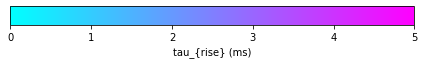

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

minv = 0.0 
maxv = 5.000471226641927

# 创建自定义的颜色映射
cmap = cm.cool
colormap = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=minv, vmax=maxv))

# 创建一个新的图形和轴
fig, ax = plt.subplots(figsize=(6, 1))

# 绘制颜色条
cbar = plt.colorbar(colormap, cax=ax, orientation='horizontal')
cbar.set_label('tau_{rise} (ms)')
cbar.set_ticks(np.arange(0, 6, 1))
cbar.set_ticklabels([f'{i}' for i in np.arange(0, 6, 1)])

# 设置图的边界
plt.tight_layout()

# 保存为 EPS 格式
plt.savefig('colorbar.eps', format='eps')

# 显示图形（可选）
plt.show()
